### Query Planning & Decomposition

Query planning and decomposition is a technique where a complex user query is broken down into simpler sub-questions or tasks, allowing a system(lie a RAG agent) to:

* understand the question mode deeply
* retrieve more precise and complete information
* execute step by step reasoning

##### Steps:
* add a query planner node
* break complex user queries into sub-questions
* retrieve docs per sub-question
* combine all retrieved contexts
* generate a final consolidated answer

In [1]:
#importing libraries
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain.chat_models import init_chat_model


d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
urls=['https://docs.langchain.com/oss/python/langchain/agents',
'https://docs.langchain.com/oss/python/langchain/tools',
'https://docs.langchain.com/oss/python/langchain/streaming']

documents = WebBaseLoader(web_paths=urls).load()
chunks = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100).split_documents(documents)
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

retriever = FAISS.from_documents(documents=chunks,
                                 embedding=embeddings).as_retriever()

In [3]:
#base model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002441D389050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002441CD53B90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
#state schema
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document

class State(BaseModel):
    question: str
    sub_questions: str = ""
    combined_docs: List[Document] = []
    answer: str = ""

In [5]:
#defining nodes
from langchain.agents import create_agent
from typing_extensions import TypedDict

class Context(TypedDict):
    info: str


def query_decompose(state:State)->State:
    'this function breaks or decomposes the given complex query into simple sub_queries'
    prompt = """for the given question, break or decompose into only two simple sub questions"""
    decompose_agent = create_agent(model=model,
                                   system_prompt=prompt)
    response = decompose_agent.invoke({"messages":[{"role":"user", "content": state.question}]})
    return state.model_copy(update={"sub_questions": response['messages'][-1].content})

def retrieve_docs(state:State)->State:
    'this function retrieves relevant documents for given sub_questions'
    sub_queries = state.sub_questions.split("\n\n")
    all_docs=[]
    for question in sub_queries:
        relevant_docs = retriever.invoke(question)
        all_docs.extend(relevant_docs)
    return state.model_copy(update={"combined_docs": all_docs})

def generate_answer(state:State)->State:
    'this function is used to generate answer for the user question, based on the aggregated documents provided '
    aggregated_docs = "\n\n".join([doc.page_content for doc in state.combined_docs])
    answer_model = create_agent(model=model,
                                system_prompt='provide anser to the question only based on context information provided.',
                                context_schema=Context) 
    answer_model_res = answer_model.invoke({"messages":[{"role":"user", "content": state.question}]}, context={"info":aggregated_docs})
    return state.model_copy(update={"answer": answer_model_res['messages'][-1].content})




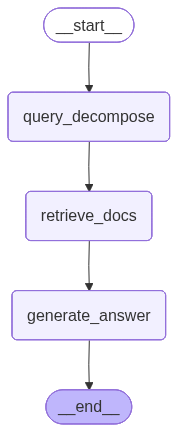

In [6]:
#defining graph workflow
from langgraph.graph import StateGraph, START, END
graph = StateGraph(State)

graph.add_node("query_decompose", query_decompose)
graph.add_node("retrieve_docs", retrieve_docs)
graph.add_node("generate_answer", generate_answer)

graph.add_edge(START, "query_decompose")
graph.add_edge("query_decompose", "retrieve_docs")
graph.add_edge("retrieve_docs", "generate_answer")
graph.add_edge("generate_answer", END)

graph_builder = graph.compile()
graph_builder

In [12]:
query = "what is streaming with human-in-the-loop"
state=State(question=query)
rag_response = graph_builder.invoke(state)
rag_response

{'question': 'what is streaming with human-in-the-loop',
 'sub_questions': 'Here are two simple sub questions to break down the concept of streaming with human-in-the-loop:\n\n1. What is human-in-the-loop?\n\n2. What is streaming and how does it relate to human-in-the-loop?',
 'combined_docs': [Document(id='5bdb82e3-ede5-4de6-9b2f-00b94c9b6c2f', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/streaming', 'title': 'Streaming - Docs by LangChain', 'language': 'en'}, page_content='\u200bStreaming with human-in-the-loop\nTo handle human-in-the-loop interrupts, we build on the above example:\n\nWe configure the agent with human-in-the-loop middleware and a checkpointer\nWe collect interrupts generated during the "updates" stream mode\nWe respond to those interrupts with a command'),
  Document(id='49b67f6f-bef6-45bb-abae-d0597895ddf3', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/streaming', 'title': 'Streaming - Docs by LangChain', 'language': '

In [14]:
print(rag_response['sub_questions'])

Here are two simple sub questions to break down the concept of streaming with human-in-the-loop:

1. What is human-in-the-loop?

2. What is streaming and how does it relate to human-in-the-loop?


In [15]:
print(rag_response['answer'])

Based on the context of the term "streaming with human-in-the-loop," I can provide the following information:

Streaming with human-in-the-loop (HITL) refers to a real-time data processing approach that incorporates human judgment and decision-making into the data analysis and processing pipeline. 

In this context, a human expert or decision-maker is integrated into the data streaming process, often through a user interface or interactive system. They can review, validate, or correct the data, models, and decisions in real-time, allowing for more accurate and context-dependent outputs.

The human-in-the-loop approach is often used in applications such as:

1. **Data labeling and validation**: Human annotators or experts verify and correct labeled data to improve model performance and accuracy.
2. **Model interpretability and explainability**: Humans provide insights and context to complex model outputs, enabling better decision-making.
3. **Decision-making and risk assessment**: Human